<h3> Importy </h3>

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

<h3> Przygotowanie danych </h3>
- Ustawienia urządzenia </br>
- Konwersja obrazu na znormalizowany tensor PyTorch 
&& normalizacja danych do wartości z zakresu [-1.0; 1.0] </br>
- Pobranie danych treningowych i testowych

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:56<00:00, 467kB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 92.7kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:08<00:00, 519kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.15MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



<h3> Implementacja funkcji pomocniczych wykorzystywanych w zadaniu </h3>
- <b>Tworzenie podzbioru danych</b>, <i>zawierającego określony procent <b>losowych</b> danych (permutacja).</i></br>
- <b>Dodanie szumu Gaussa.</b> <i>Szum gaussowski to losowe zakłócenie o rozkładzie normalnym, stosowane w celu zwiększenia odporności modelu na zakłócenia w danych wejściowych</i> </br>


In [4]:
def get_subset(dataset, percentage):
    subset_size = int(len(dataset) * percentage)
    indices = torch.randperm(len(dataset))[:subset_size]
    return torch.utils.data.Subset(dataset, indices)

def add_gaussian_noise(data, std_dev):
    noise = torch.normal(0, std_dev, size=data.shape).to(data.device)
    return data + noise


<h3> Definiowanie modelu prostej sieci neuronowej </h3>

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(SimpleNN, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [num_classes]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


<h3> Trenowanie modelu </h3>

1. **Trening modelu:**
   - Przechodzi przez dane treningowe w wielu epokach.
   - Dla każdej epoki oblicza stratę (Loss) i aktualizuje wagi.
   - <i>Dodanie szumu do danych wejściowych (opcjonalne).</i>

2. **Ocena modelu:**
   - Po każdej epoce model jest oceniany na danych testowych.
   - Obliczana jest dokładność (Accuracy), która wskazuje, jak dobrze model radzi sobie na nowych danych, które nie były używane do trenowania.

3. **Wyniki:**
   - Funkcja zwraca dwie listy: jedną z wartościami strat dla treningu oraz drugą z dokładnością na danych testowych.


In [6]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs, noise_std=0.0):
    model = model.to(device)
    train_losses, test_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
            if noise_std > 0:
                inputs = add_gaussian_noise(inputs, noise_std)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))

        # Ewaluacja
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
                if noise_std > 0:
                    inputs = add_gaussian_noise(inputs, noise_std)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

<h3> Przeprowadzenie eksperymentów

In [7]:
input_size = 28 * 28
num_classes = 10
batch_sizes = [16, 64]
hidden_layer_sizes = [[128], [128, 64]]
train_sizes = [0.01, 0.1]
noise_stds = [0.0, 0.1, 0.2]
epochs = 10
learning_rate = 0.01

results = {}
criterion = nn.CrossEntropyLoss()

for train_size in train_sizes:
    for batch_size in batch_sizes:
        for hidden_sizes in hidden_layer_sizes:
            for noise_std in noise_stds:
                train_loader = torch.utils.data.DataLoader(get_subset(train_data, train_size), batch_size=batch_size, shuffle=True)
                test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
                model = SimpleNN(input_size, hidden_sizes, num_classes)
                optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                print(f"\nTrain size: {train_size*100}%, Batch size: {batch_size}, Hidden sizes: {hidden_sizes}, Noise std: {noise_std}")
                losses, accuracies = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs, noise_std)
                results[(train_size, batch_size, tuple(hidden_sizes), noise_std)] = (losses, accuracies)



Train size: 1.0%, Batch size: 16, Hidden sizes: [128], Noise std: 0.0
Epoch 1/10, Loss: 2.0059, Accuracy: 46.25%
Epoch 2/10, Loss: 1.5253, Accuracy: 57.16%
Epoch 3/10, Loss: 1.2123, Accuracy: 61.29%
Epoch 4/10, Loss: 1.0297, Accuracy: 63.51%
Epoch 5/10, Loss: 0.9140, Accuracy: 68.23%
Epoch 6/10, Loss: 0.8277, Accuracy: 71.83%
Epoch 7/10, Loss: 0.7545, Accuracy: 71.94%
Epoch 8/10, Loss: 0.7139, Accuracy: 73.68%
Epoch 9/10, Loss: 0.6706, Accuracy: 70.89%
Epoch 10/10, Loss: 0.6403, Accuracy: 74.40%

Train size: 1.0%, Batch size: 16, Hidden sizes: [128], Noise std: 0.1
Epoch 1/10, Loss: 2.0111, Accuracy: 54.40%
Epoch 2/10, Loss: 1.4931, Accuracy: 59.12%
Epoch 3/10, Loss: 1.1776, Accuracy: 68.43%
Epoch 4/10, Loss: 0.9834, Accuracy: 70.31%
Epoch 5/10, Loss: 0.8679, Accuracy: 68.97%
Epoch 6/10, Loss: 0.7849, Accuracy: 71.00%
Epoch 7/10, Loss: 0.7243, Accuracy: 70.95%
Epoch 8/10, Loss: 0.6803, Accuracy: 72.24%
Epoch 9/10, Loss: 0.6415, Accuracy: 72.61%
Epoch 10/10, Loss: 0.6084, Accuracy: 72.

<h3>Wizualizacja wyników na wykresach

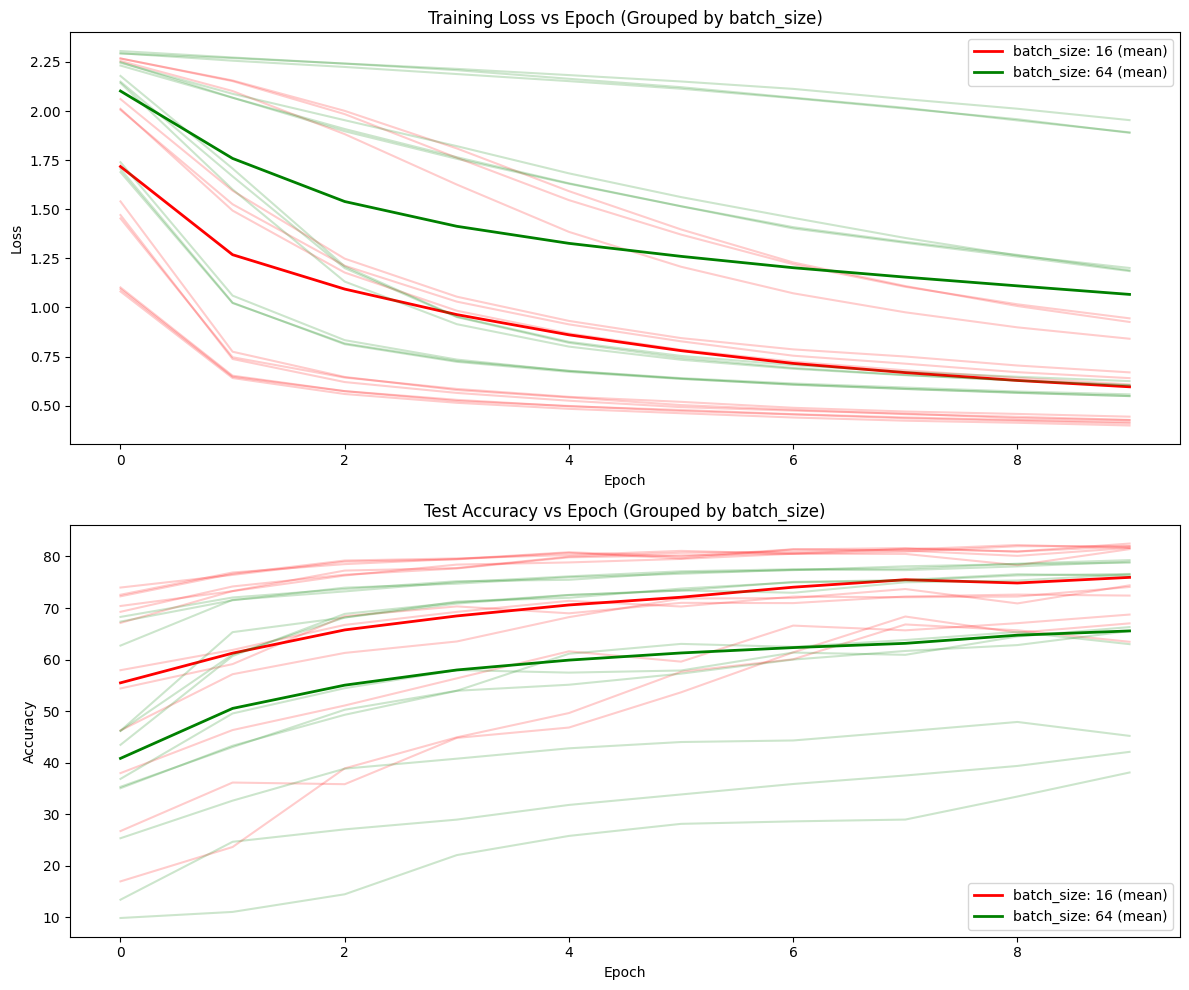

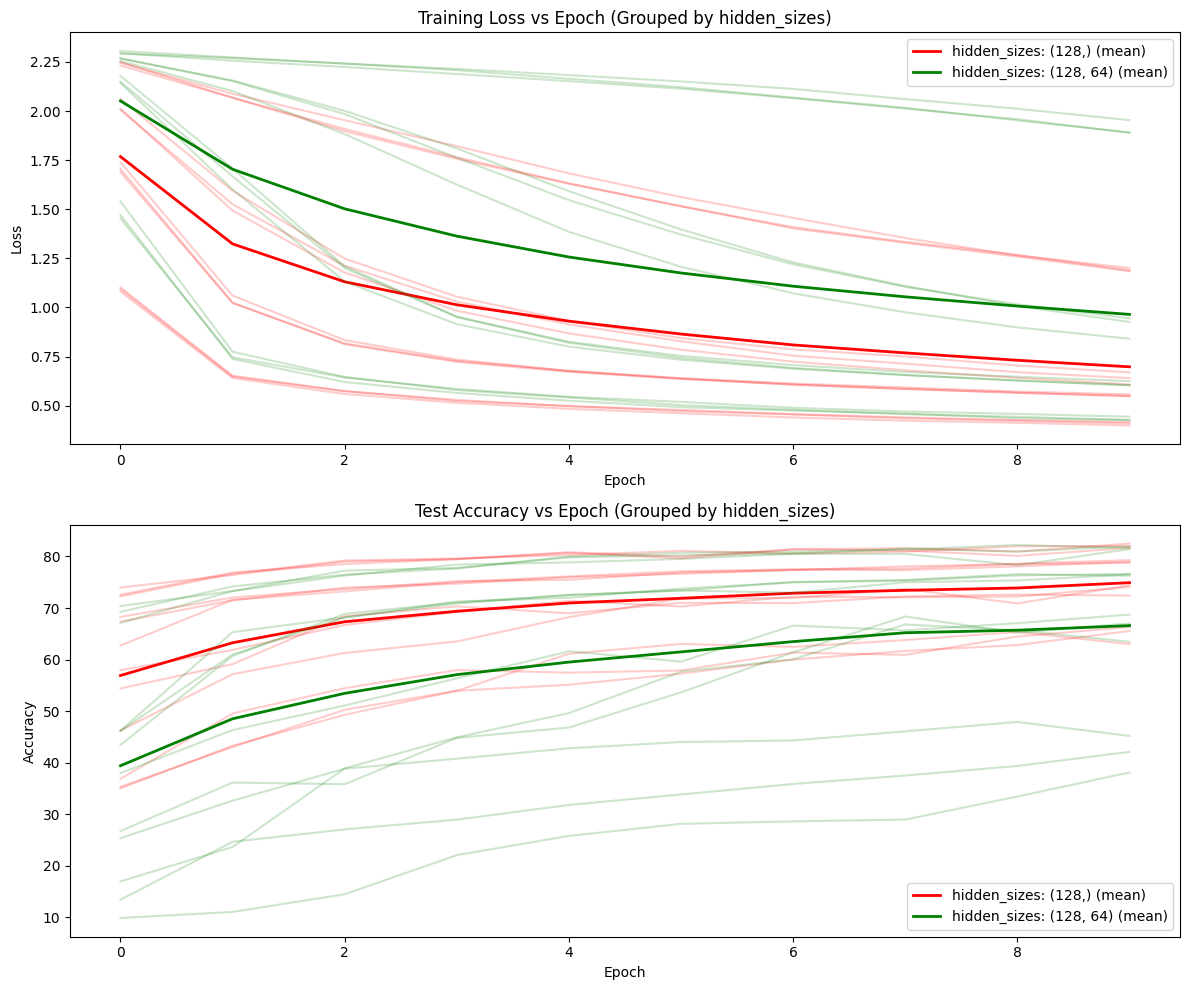

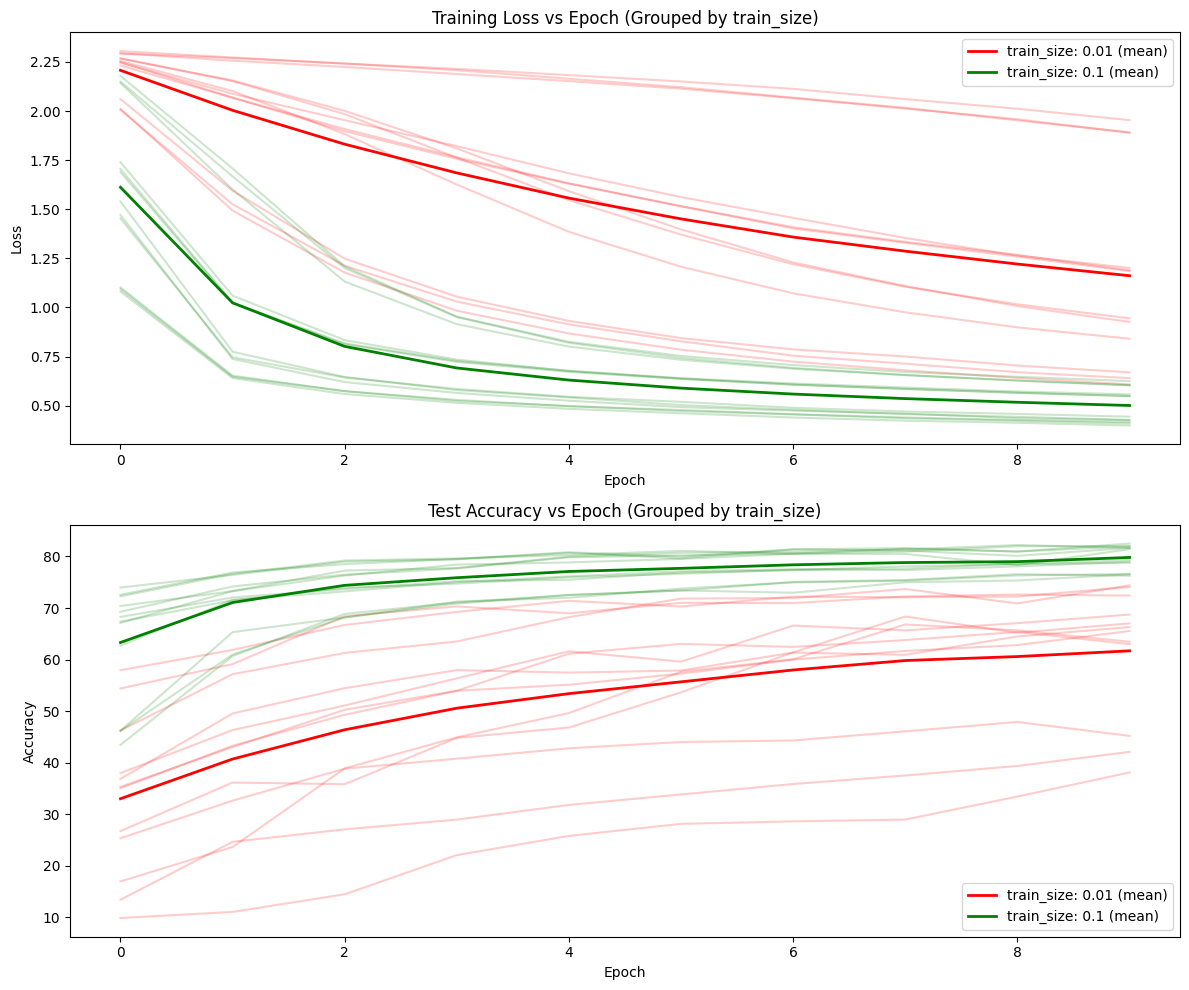

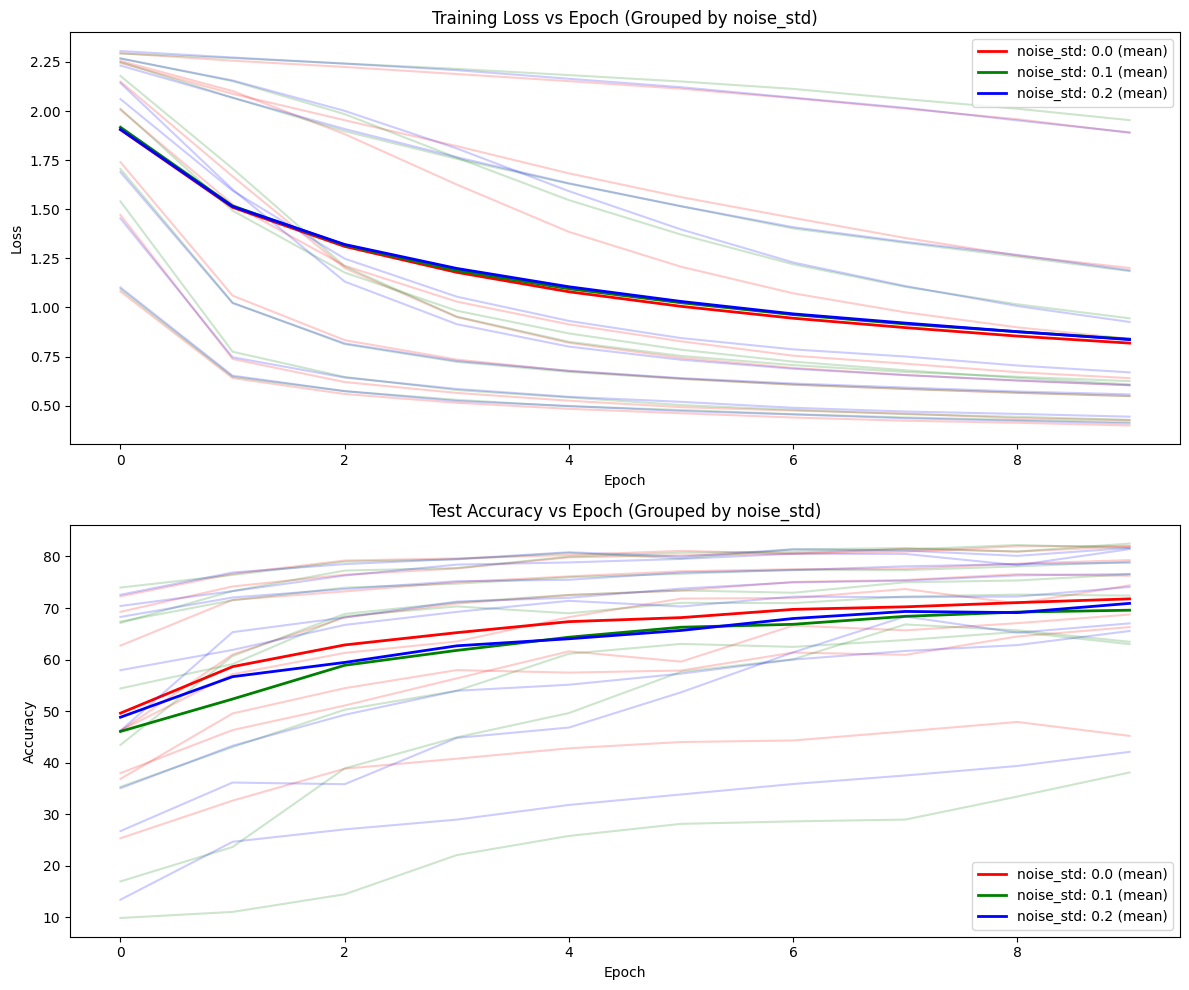

In [ ]:
def plot_results(results, values, colors, param):
    plt.figure(figsize=(12, 10))

    losses_by_param = {value: [] for value in values}
    accuracies_by_param = {value: [] for value in values}

    for key, (losses, accuracies) in results.items():
        train_size, batch_size, hidden_sizes, noise_std = key

        if param == "batch_size":
            param_value = batch_size
        elif param == "hidden_sizes":
            param_value = tuple(hidden_sizes)
        elif param == "train_size":
            param_value = train_size
        elif param == "noise_std":
            param_value = noise_std
        else:
            raise ValueError("Invalid parameter name!")

        if param_value in values:
            losses_by_param[param_value].append(losses)
            accuracies_by_param[param_value].append(accuracies)

    plt.subplot(2, 1, 1)
    for value, color in zip(values, colors):
        all_losses = np.array(losses_by_param[value])
        mean_loss = np.mean(all_losses, axis=0) if all_losses.size > 0 else None
        for losses in losses_by_param[value]:
            plt.plot(losses, color=color, alpha=0.2)
        if mean_loss is not None:
            plt.plot(mean_loss, color=color, linewidth=2, label=f"{param}: {value} (mean)")
    plt.title(f"Training Loss vs Epoch (Grouped by {param})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    for value, color in zip(values, colors):
        all_accuracies = np.array(accuracies_by_param[value])
        mean_accuracy = np.mean(all_accuracies, axis=0) if all_accuracies.size > 0 else None
        for accuracies in accuracies_by_param[value]:
            plt.plot(accuracies, color=color, alpha=0.2)
        if mean_accuracy is not None:
            plt.plot(mean_accuracy, color=color, linewidth=2, label=f"{param}: {value} (mean)")
    plt.title(f"Test Accuracy vs Epoch (Grouped by {param})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(results, batch_sizes, ["red", "green"], "batch_size")
plot_results(results, [tuple(size) for size in hidden_layer_sizes], ["red", "green"], "hidden_sizes")
plot_results(results, train_sizes, ["red", "green"], "train_size")
plot_results(results, noise_stds, ["red", "green", "blue"], "noise_std")

<h3> Wnioski</h3>
- <b>batch_size</b> o wartości 16 średnio spisał się lepiej niż ten o wartości 64<br>
- <b>hidden_layer_size</b> lepszymi wynikiami może pochwalić się prostsza sieć<br>
- <b>train_size</b> stanowiący 10% danych testowych spisał się lepiej niż ten stanowiący ich 1%<br>
- <b>noise_std</b> niezależnie od wartości szumu sieci potrafiły poprawnie zidentyfikować obiekty